# About

This notebook outlines the analysis done for project "Book recommendation system". <br>
For this project, we have taken the goodreads book rating data. Given the rating data the objective is to use it in a way to give product recommendations.

# 1. Importing the data

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

%matplotlib inline

## Ratings dataset

The first dataframe that we are going to import is the Ratings dataset. THis contains information about the user ratings of different books that the users have read in the past

In [2]:
ratings = pd.read_csv("./data/ratings.csv")
print(f'Row and columns : {ratings.shape}')
ratings.head(2)

Row and columns : (5976479, 3)


,user_id,book_id,rating
0,1,258,5
1,2,4081,4


In this dataframe, we have around 5 million book ratings

In [3]:
# memory usage in MB
ratings.memory_usage() / 1024 / 1024

Index       0.000122
user_id    45.596916
book_id    45.596916
rating     45.596916
dtype: float64

## Books dataset

This dataset contain the metadata about the books present in the database

In [4]:
books = pd.read_csv("./data/books.csv")
print(f'Row and columns : {books.shape}')
books.head(2)

Row and columns : (10000, 23)


,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...


Although the dataset contain many useful features that can be used for book recommendation problem. We will primarily be focusing on the <b>user and book interactions</b> to find the recommendations.<br>
And, how do we plan on doing that ?<br>
We will be using clever mathematical technique that are designed to project high dimensional data in low dimensional spaces.

In [5]:
books_ = books.loc[:, ["book_id", "goodreads_book_id", "isbn", "authors", "original_title", "image_url"]]

# important meta data about the books to display later in the recommended list
books_.head(2)

,book_id,goodreads_book_id,isbn,authors,original_title,image_url
0,1,2767052,439023483,Suzanne Collins,The Hunger Games,https://images.gr-assets.com/books/1447303603m...
1,2,3,439554934,"J.K. Rowling, Mary GrandPré",Harry Potter and the Philosopher's Stone,https://images.gr-assets.com/books/1474154022m...


We will be using the image url to show the recommended book images in the final application. Let us test out if the links retrive an image

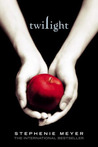

In [6]:
# test method to download and display images

import urllib
import urllib.request
from PIL import Image
from io import BytesIO

with urllib.request.urlopen(books_.iloc[2, :].image_url) as fh:
    _ = fh.read()
    _ = Image.open(BytesIO(_))
    
_

# 2. Exploratory data analysis

We will be exploting the ratings dataframe to understand the user behaviour with respect to the movies and vice versa

## 2.1 Basic details of ratings

In [7]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
ratings.describe()["rating"]

count   5976479.000
mean          3.920
std           0.991
min           1.000
25%           3.000
50%           4.000
75%           5.000
max           5.000
Name: rating, dtype: float64

Our ratings from user, lie between the values [1-5].
 
Median rating from all users is at 4.0, and 75th percentile rating == MAX RATING. So, could be that most of the readers end up rating the books high, or there are many books with high rating than otherwise.

In [8]:
ratings.duplicated().sum()

0

There are no duplicates in the rating data

## 2.2 Extract only a piece of the very large dataset
Our original dataset contains a total of **5 million, which can be very difficult to process on this laptop.**
 
So, we take a proportion of the overall data, around 50k user interactions. 

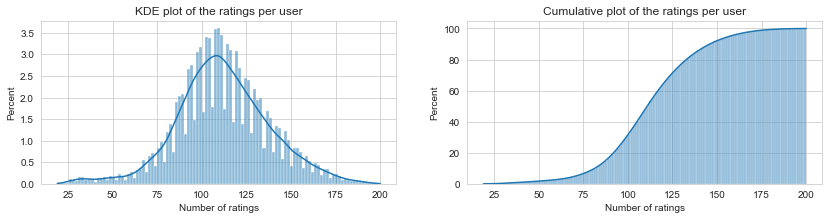

In [45]:
# We filter the rating data to only take users who have rated at least 4 

_ = ratings.groupby("user_id").size()
ratings_groupby_user = _

fig, (ax0, ax1) = plt.subplots(1, 2, figsize = (14, 3))

ax0.set(title ="KDE plot of the ratings per user", xlabel = "Number of ratings")
sns.histplot(x = _, ax=ax0, cumulative=False, kde = True, fill=True, stat="percent")

ax1.set(title ="Cumulative plot of the ratings per user" , xlabel = "Number of ratings")
sns.histplot(x = _, ax=ax1, cumulative=True, kde = True, fill=True, binwidth=1, stat="percent")

plt.show()

In [46]:
print("Total data")
print("*"*50)
print("Total number of ratings: ", ratings.rating.size )
print("Total number of users: ", ratings.user_id.nunique())
print("Total number of books: ", ratings.book_id.nunique())
print("-"*50)
print("Total number of ratings per user: ", ratings.rating.size / ratings.user_id.nunique() )
print("Total number of ratings per book: ", ratings.rating.size / ratings.book_id.nunique() )

Total data
**************************************************
Total number of ratings:  5976479
Total number of users:  53424
Total number of books:  10000
--------------------------------------------------
Total number of ratings per user:  111.86880428271938
Total number of ratings per book:  597.6479


### 2.2.1 Sampling to get a small proportion of the original dataset
In order to pick around 50k user interactions from the big dataset. We 

In [47]:
Y = ratings.user_id.map(dict(np.c_[ratings_groupby_user.index, ratings_groupby_user.values]))
Y_cuts = pd.cut(Y, bins = 5)

ratings_groupby_user = ratings_groupby_user.to_frame().reset_index().assign(Y_cuts = Y_cuts).drop(columns=[0])
ratings_groupby_user.head(2)

,user_id,Y_cuts
0,1,"(91.4, 127.6]"
1,2,"(55.2, 91.4]"


Run stratified sampling to pick a subset of users while maintining the overall shape of distribution

In [48]:
from sklearn.model_selection import StratifiedShuffleSplit
X = ratings_groupby_user.user_id
Y = ratings_groupby_user.Y_cuts

strata = StratifiedShuffleSplit(n_splits=1, train_size=0.01, random_state=2)
for index, temp in strata.split(X, Y):
    ratings_groupby_user_strata = ratings_groupby_user.iloc[index, :]
    
print(ratings_groupby_user_strata.shape)
ratings_groupby_user_strata.head()

(534, 2)


,user_id,Y_cuts
10667,10668,"(18.819, 55.2]"
22399,22400,"(55.2, 91.4]"
38246,38247,"(127.6, 163.8]"
32167,32168,"(163.8, 200.0]"
22966,22967,"(91.4, 127.6]"


In [49]:
ratings_ = ratings.loc[ratings.user_id.isin(ratings_groupby_user_strata.user_id)]
ratings_.shape

(60127, 3)

Around 534 users with a total of 60k rating have been picked from the big dataset

In [50]:
print("Total data")
print("*"*50)
print("Total number of ratings: ", ratings_.rating.size )
print("Total number of users: ", ratings_.user_id.nunique())
print("Total number of books: ", ratings_.book_id.nunique())
print("-"*50)
print("Total number of ratings per user: ", ratings_.rating.size / ratings_.user_id.nunique() )
print("Total number of ratings per book: ", ratings_.rating.size / ratings_.book_id.nunique() )

Total data
**************************************************
Total number of ratings:  60127
Total number of users:  534
Total number of books:  8784
--------------------------------------------------
Total number of ratings per user:  112.59737827715355
Total number of ratings per book:  6.845059198542805


In the sampled dataset, we have a total of 60k ratings, around 500 users and 8k books. The sampling has been done to preserve the distributon of "books rated per user" 

### 2.2.2 Distribution of ratings (sampled dataset)

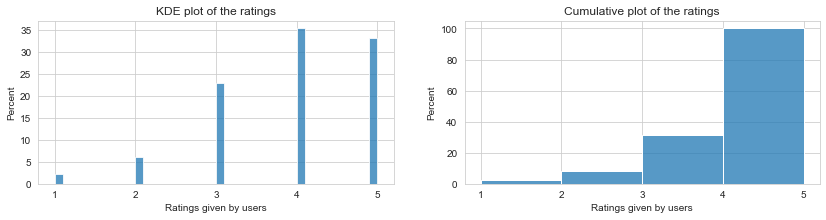

In [84]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize = (14, 3))

ax0.set(title ="KDE plot of the ratings", xlabel = "Ratings given by users")
sns.histplot(data = ratings_, x = "rating", ax=ax0, cumulative=False, kde = False, fill=True, stat="percent")
ax0.set_xticks([1, 2, 3, 4, 5])

ax1.set(title ="Cumulative plot of the ratings", xlabel = "Ratings given by users")
sns.histplot(data = ratings_, x = "rating", ax=ax1, cumulative=True, kde = False, fill=True, binwidth=1, stat="percent")
ax1.set_xticks([1, 2, 3, 4, 5])

plt.show()

Observations - 
1. Most of the ratings, around **65 percent** are either 4 or 5. So, goodreads as a platform has a very high average global rating.
2. Less than **15 percent** of total rating are either [1, 2]. 
 > This suggests that a good recommender should do specially good at predicting the low ratings*. 
3. Around **1/4th** of the total ratings are neutral or [3]

### 2.2.3 Number of books rated per users (sampled dataset)

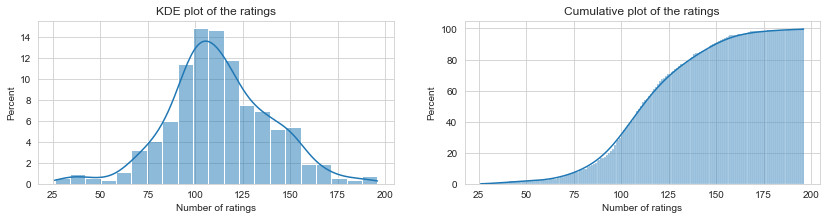

In [52]:
_ = ratings_.groupby("user_id").size()

fig, (ax0, ax1) = plt.subplots(1, 2, figsize = (14, 3))

ax0.set(title ="KDE plot of the ratings", xlabel = "Number of ratings")
sns.histplot(x = _, ax=ax0, cumulative=False, kde = True, fill=True, stat="percent")

ax1.set(title ="Cumulative plot of the ratings" , xlabel = "Number of ratings")
sns.histplot(x = _, ax=ax1, cumulative=True, kde = True, fill=True, binwidth=1, stat="percent")

plt.show()

Observations - 
1. The metric follows a nearly normal distribution
2. On an avg, users rate around 112 books
3. Very few users rate less than 25 books, and more than 150 books

### 2.2.4 Number of books in each rating category

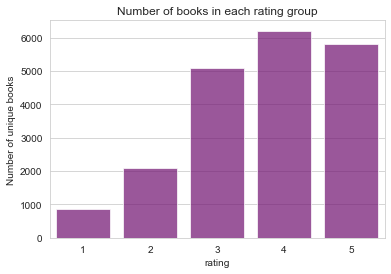

In [125]:
_ = ratings_.groupby("rating")["book_id"].nunique()
_ = _.to_frame().reset_index()

sns.barplot(data=_, x = "rating", y = "book_id", color="purple", alpha=0.7)
plt.ylabel("Number of unique books")
plt.title("Number of books in each rating group")

plt.show()

Again, same observation - 
1. High percentage of books have received a 4 or 5 star rating on this platform

### 2.2.5 Number of ratings received by each book by users

<Figure size 1080x432 with 0 Axes>

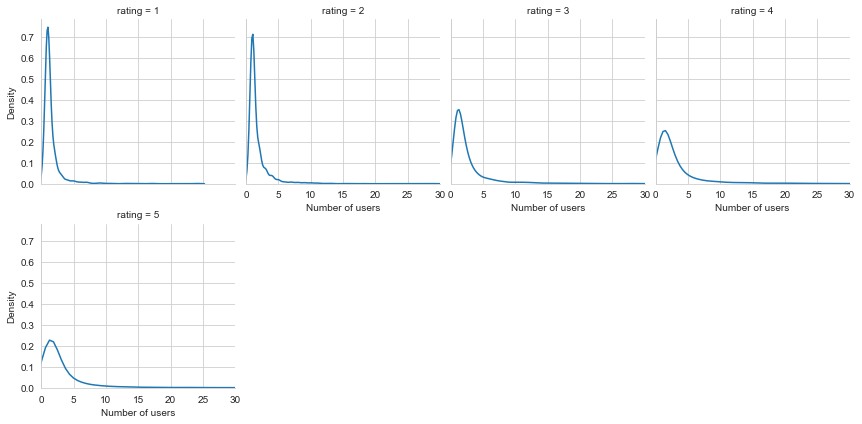

In [128]:
_ = ratings_.groupby(["rating", "book_id"]).size().reset_index().rename(columns={0:"Number of users"})

plt.figure(figsize=(15, 6))
sns.FacetGrid(data = _, col= "rating", col_wrap=4).map(sns.kdeplot, "Number of users")
plt.xlim((0, 30))
plt.show()

For each of the rating category, we observe that -
1. Most of the books have been rated by 3-4 users
2. With the exception of books, that have been rated by a lot of users, but that is not the mode

# 3. Creating the recommendation system

We will be exploting the ratings dataframe to understand the user behaviour with respect to the movies and vice versa.
  <br><br>
We will make use of the SVD to find the low dimension embeddings of the items. Finally, we will be using these embeddings in conjunction with a similarity metric to find the top recommendations for the user search item.
 


In [359]:
from scipy.sparse.linalg import svds
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity

# We will be implementing this class to 
class SVD_recommender(object):
    def __init__(self, processed_ratings_matrix, user_index, item_index):
        self.data = processed_ratings_matrix
        self.U = None
        self.Vt = None
        self.sigma = None
        self.sigmaVt_T = None
        self.results = None
        self.user_idx = user_index
        self.item_idx = item_index
        
    def fit(self, k = 10):
        self.U, self.sigma, self.Vt = svds(self.data, k)
        self.sigma = np.diag(self.sigma)
        self.sigmaVt_T = np.dot(self.sigma, self.Vt).T
    
    def recommend_with_itemid(self, item_id):
        if item_id not in self.item_idx:
            raise KeyError
    
        idx = np.where(self.item_idx == item_id)[0][0]
        item = [self.sigmaVt_T[idx]]
        
        scores = cosine_similarity(self.sigmaVt_T, item)[:, 0]
        return pd.DataFrame({"item_id": self.item_idx, "scores": scores}).sort_values("scores", ascending = False).query("item_id != @item", )
        

In [360]:
# Process the existing rating matrix to be used further

ratings_pivot = pd.pivot(data = ratings_, index = "user_id", columns="book_id", values="rating")#.reset_index()
print(ratings_pivot.shape)

(534, 8784)


In [361]:
book_index = ratings_pivot.columns.to_numpy()
user_index = ratings_pivot.index.to_numpy()

ratings_normal = ratings_pivot.fillna(0).to_numpy() - ratings_pivot.mean(axis=1).to_numpy().reshape(-1, 1) 

In [362]:
recommender = SVD_recommender(ratings_normal, user_index, book_index)
recommender.fit(k = 20)

In [365]:
_ = recommender.recommend_with_itemid(2).head(10)
_

,item_id,scores
1,2,1.000
23,24,0.915
22,23,0.915
26,27,0.911
17,18,0.911
20,21,0.911
24,25,0.911
6,7,0.904
18,19,0.871
52,53,0.859


In [366]:
books.loc[books.book_id.isin(_.item_id)].loc[:, ["original_title", "image_url"]]

,original_title,image_url
1,Harry Potter and the Philosopher's Stone,https://images.gr-assets.com/books/1474154022m...
6,The Hobbit or There and Back Again,https://images.gr-assets.com/books/1372847500m...
17,Harry Potter and the Prisoner of Azkaban,https://images.gr-assets.com/books/1499277281m...
18,The Fellowship of the Ring,https://images.gr-assets.com/books/1298411339m...
20,Harry Potter and the Order of the Phoenix,https://images.gr-assets.com/books/1387141547m...
22,Harry Potter and the Chamber of Secrets,https://images.gr-assets.com/books/1474169725m...
23,Harry Potter and the Goblet of Fire,https://images.gr-assets.com/books/1361482611m...
24,Harry Potter and the Deathly Hallows,https://images.gr-assets.com/books/1474171184m...
26,Harry Potter and the Half-Blood Prince,https://images.gr-assets.com/books/1361039191m...
52,Eragon,https://images.gr-assets.com/books/1366212852m...


## Store useful data to the app/data folder to be used for application

In [370]:
import pickle

with open("./app/data/books.pkl", "wb") as f:
    pickle.dump(books.to_dict(), f)
    
with open("./app/data/recommender.pkl", "wb") as f:
    pickle.dump(recommender, f)
    
with open("./app/data/ratings_subset.pkl", "wb") as f:
    pickle.dump(ratings_, f)